# Latent representation analysis
In this notebook we analyse and compare the latent representations produced by the Wav2Vec2 feature extractor and the brain feature extractor

## Preperation

In [50]:
from src.args.yaml_config import YamlConfig
from src.args.base_args import B2TDatasetArgsModel
from src.datasets.brain2text_w_phonemes import Brain2TextWPhonemesDataset
import os
from pydub import AudioSegment
from elevenlabs import save
from elevenlabs.client import ElevenLabs
from typing import cast
from src.model.w2v_no_encoder import Wav2Vec2WithoutTransformerModel
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2Config,
)
import soundfile
import numpy as np
import torch

yaml_config = YamlConfig().config
working_dir = os.path.join(yaml_config.cache_dir, "latent_analysis")

os.makedirs(working_dir, exist_ok=True)
assert yaml_config.elevenlabs_api_key is not None, "Please provide an ElevenLabs API key in the YAML config file"
client = ElevenLabs(
    api_key=yaml_config.elevenlabs_api_key,
)

def generate_speech(transcription: str, out_mp3_path: str):
    audio = client.text_to_speech.convert(
        voice_id="pMsXgVXv3BLzUgSXRplE",
        optimize_streaming_latency="0",
        output_format="mp3_22050_32",
        text=transcription,
    )
    save(audio, out_mp3_path)

def convert_mp3_to_wav(mp3_path: str, wav_path: str):
    audio = AudioSegment.from_file(mp3_path, format="mp3", frame_rate=44100)
    audio = audio.set_frame_rate(16000)
    audio.export(wav_path, format="wav")

### Extract test transcriptions

In [51]:
test_ds = Brain2TextWPhonemesDataset(B2TDatasetArgsModel(limit_samples=100), yaml_config, "test")
test_transcriptions = [test_ds[i].transcription for i in range(len(test_ds))]


### Generate speech for test transcriptions

In [52]:
mp3_out = os.path.join(working_dir, "mp3")
os.makedirs(mp3_out, exist_ok=True)
wav_out = os.path.join(working_dir, "wav")
os.makedirs(wav_out, exist_ok=True)

def generate_wav(index: int, override_existing: bool = False)-> bool:
    transcription = test_transcriptions[index]
    mp3_path = os.path.join(mp3_out, f"{index}.mp3")
    newly_created=False
    if not os.path.exists(mp3_path) or override_existing:
        generate_speech(transcription, mp3_path)
        newly_created = True
    wav_path = os.path.join(wav_out, f"{index}.wav")
    if not os.path.exists(wav_path) or override_existing:
        convert_mp3_to_wav(mp3_path, wav_path)
    return newly_created

num_generated = 0
for i in range(len(test_ds)):
    newly_generated = generate_wav(i)
    if newly_generated:
        num_generated += 1
    print(f"\r{i+1}/{len(test_ds)} audios generated ({num_generated} newly generated)", end="")
print("\n")

100/100 audios generated (0 newly generated)



## Generate audio latent representations

In [53]:
def load_wav_as_tensor(path: str):
    wav = soundfile.read(path)
    return torch.tensor(wav[0], dtype=torch.float32)

w2v_config = cast(
    Wav2Vec2Config,
    Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base-960h"),
)

w2v_feature_extractor = cast(
    Wav2Vec2WithoutTransformerModel,
    Wav2Vec2WithoutTransformerModel.from_pretrained(
        "facebook/wav2vec2-base-960h", config=w2v_config, cache_dir=yaml_config.cache_dir
    ),
)
w2v_feature_extractor.eval()

def generate_audio_representations() -> list[torch.Tensor]:
    audio_representations: list[torch.Tensor| None] = [None] * len(test_ds)
    with torch.no_grad():
        num_generated = 0
        for i, filename in enumerate(os.listdir(wav_out)):
            idx = int(filename.split(".")[0])
            if idx >= len(test_ds):
                continue
            wav_path = os.path.join(wav_out, filename)
            wav_tensor = load_wav_as_tensor(wav_path)
            features = w2v_feature_extractor.forward(wav_tensor.unsqueeze(0))
            
            audio_representations[idx] = features.mean(dim=1).squeeze()
            num_generated+=1
            print(f"\r{num_generated}/{len(test_ds)} audio representations generated ", end="")
    print("\n")
    assert None not in audio_representations
    return audio_representations # type: ignore
audio_representations:list[torch.Tensor] = generate_audio_representations() 

100/100 audio representations generated 



## Generate brain latent representations

In [54]:
from src.datasets.batch_types import B2tSampleBatch
from src.datasets.discriminator_dataset import (
    B2P2TBrainFeatureExtractorArgsModel,
    DiscriminatorDataset,
)
config = B2P2TBrainFeatureExtractorArgsModel(
    encoder_fc_hidden_sizes=[512],
    encoder_gru_hidden_size=1024,
    encoder_num_gru_layers=1,
)

brain_encoder = DiscriminatorDataset.brain_feature_extractor_from_config(
    config, "/hpi/fs00/scratch/tobias.fiedler/brain2text/experiment_results/b2p2t_gru+w2v/2024-08-20_11#57#39/brain_encoder.pt", "facebook/wav2vec2-base-960h"
)
brain_encoder.eval()


def generate_brain_representations() -> list[torch.Tensor]:
    brain_representations: list[torch.Tensor| None] = [None] * len(test_ds)
    with torch.no_grad():
        for i in range(len(test_ds)):
            batch = B2tSampleBatch(test_ds[i].input.unsqueeze(0), None)
            batch.day_idxs = torch.tensor(test_ds[i].day_idx).unsqueeze(0)
            out = brain_encoder.forward(batch.cuda())
            brain_representations[i] = out.logits.mean(dim=1).squeeze().detach().cpu() 
            print(f"\r{i+1}/{len(test_ds)} brain representations generated ", end="")
            
    print("\n")
    assert None not in brain_representations
    return brain_representations # type: ignore


brain_representations = generate_brain_representations()

100/100 brain representations generated 



## Perform Dimensionality reduction

In [55]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
all_data_np = torch.concatenate([torch.stack(audio_representations) ,torch.stack(brain_representations)]).numpy()
dim_reducer = TSNE(n_components=2)
all_data_dimreduced = dim_reducer.fit_transform(all_data_np)

### Visualize audio / brain encoder clusters

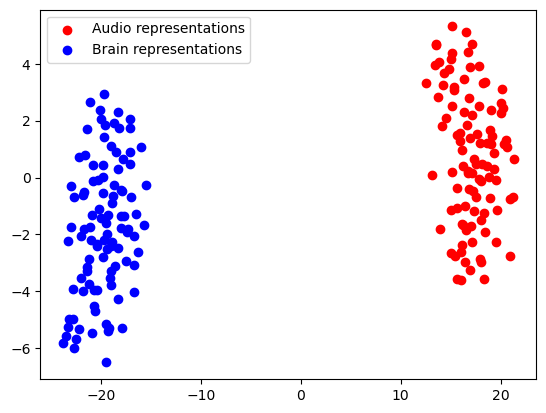

In [56]:
import matplotlib.pyplot as plt

# Show scatter plot of all_data_pca with the first len(test_set) samples in one color and the rest in another color
plt.scatter(all_data_dimreduced[:len(test_ds), 0], all_data_dimreduced[:len(test_ds), 1], c="red", label="Audio representations")
plt.scatter(all_data_dimreduced[len(test_ds):, 0], all_data_dimreduced[len(test_ds):, 1], c="blue", label="Brain representations")
plt.legend()
plt.show()

### Visualize sample pairs (brain, audio)

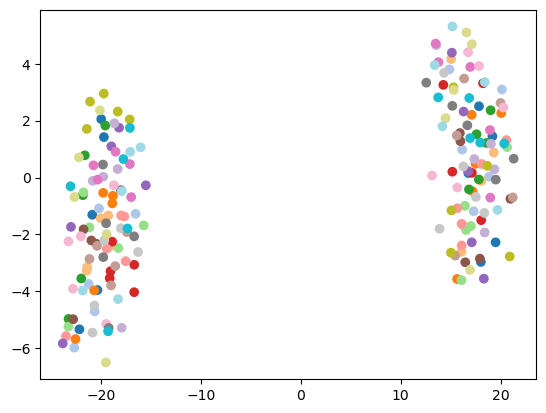

In [57]:
# Show scatter plot with each index modulo len(test_set) in one color

plt.scatter(all_data_dimreduced[:, 0], all_data_dimreduced[:, 1], c=[i % len(test_ds) for i in range(len(all_data_dimreduced))], cmap="tab20") #type: ignore

## Distance between dimensionality reduced audio and brain representation pairs

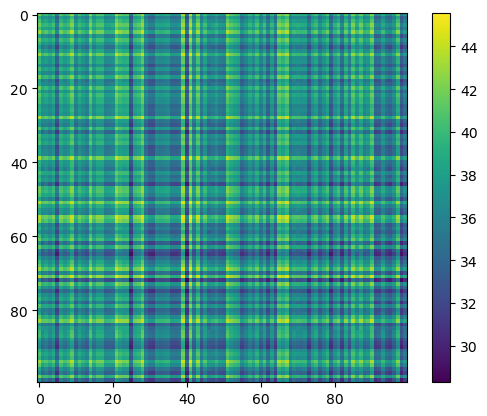

In [58]:
# Show distance matrix between dimensionality reduced audio and brain representation pairs
from scipy.spatial.distance import cdist

dimreduced_distances = cdist(all_data_dimreduced[:len(test_ds)], all_data_dimreduced[len(test_ds):],'euclidean')
plt.imshow(dimreduced_distances)
plt.colorbar()

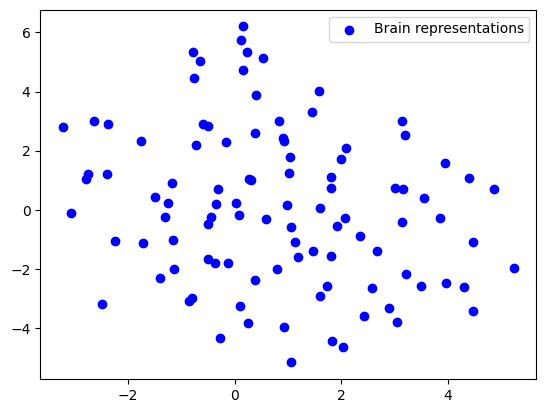

In [59]:
brain_dim_reducer =TSNE(n_components=2) #PCA(n_components=2)
brain_data_dimreduced = brain_dim_reducer.fit_transform(all_data_np[len(test_ds):])
plt.scatter(brain_data_dimreduced[:, 0], brain_data_dimreduced[:, 1], c="blue", label="Brain representations")
plt.legend()
plt.show()

## Transcription phoneme distance matrix

100% of distances calculated 

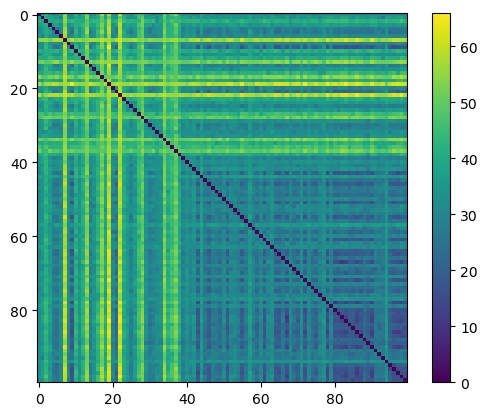

In [60]:
from edit_distance import SequenceMatcher

test_phonemes = [test_ds[i].phonemes for i in range(len(test_ds))]

label_distances = np.zeros((len(test_phonemes), len(test_phonemes)))
for i in range(len(test_phonemes)):
    for j in range(len(test_phonemes)):
        matcher = SequenceMatcher(a=test_phonemes[i], b=test_phonemes[j])
        dist = matcher.distance()
        label_distances[i][j] = dist
    print(f"\r{int(((i+1)/len(test_transcriptions))*100)}% of distances calculated ", end="")
plt.imshow(label_distances, interpolation="nearest")
plt.colorbar()

### Compute correlation between phoneme transcription distance and brain representation distance

In [61]:
np.correlate(label_distances.flatten(), cdist(brain_data_dimreduced, brain_data_dimreduced).flatten())

array([1426402.22311555])

### Relationship between transcription phoneme distance and brain representation pairs distance

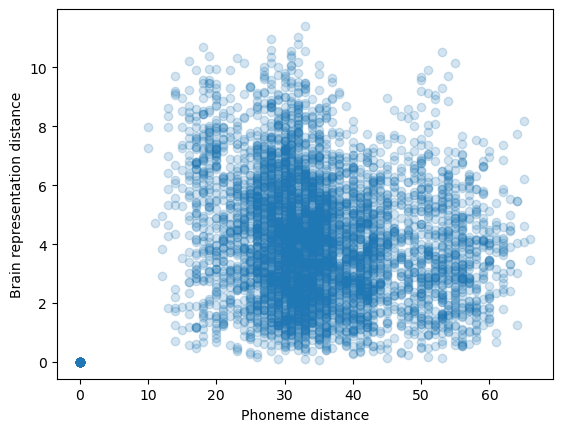

In [71]:
plt.scatter(label_distances.flatten(), cdist(brain_data_dimreduced, brain_data_dimreduced).flatten(), alpha=0.1)
plt.xlabel("Phoneme distance")
plt.ylabel("Brain representation distance")
plt.show()

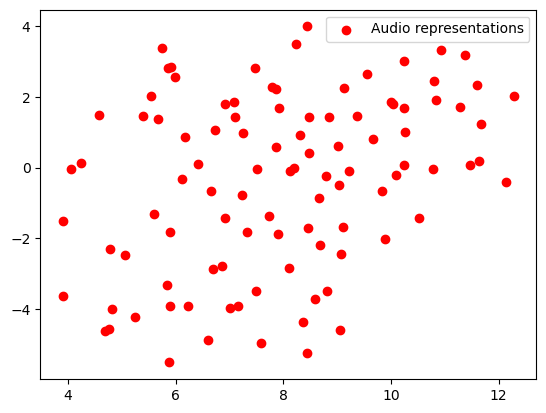

In [65]:
audio_only_dimreducer = TSNE(n_components=2)#PCA(n_components=2)
audio_data_dimreduced = audio_only_dimreducer.fit_transform(all_data_np[:len(test_ds)])
plt.scatter(audio_data_dimreduced[:, 0], audio_data_dimreduced[:, 1], c="red", label="Audio representations")
plt.legend()
plt.show()

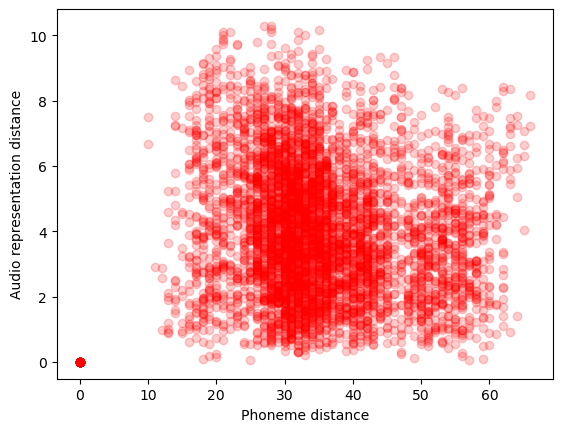

In [70]:
plt.scatter(label_distances.flatten(), cdist(audio_data_dimreduced, audio_data_dimreduced).flatten(), c="red", alpha=0.1)
plt.xlabel("Phoneme distance")
plt.ylabel("Audio representation distance")
plt.show()